<a href="https://colab.research.google.com/github/JirayuL/wild_salmon_analysis/blob/main/The_decrease_of_wild_salmon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
# STEP 2: Upload Wild CSV File
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(filename)
# df = pd.read_csv('/content/SalmonandSeaTroutNets1952-2022.csv')


Saving SalmonandSeaTroutNets1952-2022.csv to SalmonandSeaTroutNets1952-2022.csv


In [3]:
# STEP 2: Upload Farm CSV File
uploaded = files.upload()
filename = next(iter(uploaded))
farm_df = pd.read_csv(filename)

Saving Scottish Fish Farm Production Survey T24 - Atlantic salmon - Annual production of Atlantic salmon 1979-_0.csv to Scottish Fish Farm Production Survey T24 - Atlantic salmon - Annual production of Atlantic salmon 1979-_0.csv


In [4]:
# STEP 3: Prepare & Clean Data
df = df.dropna(subset=['Year', 'Netting effort'])
df['Year'] = df['Year'].astype(int)
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
df['Wild Total weight'] = df['Wild MSW weight (kg)'].fillna(0) + df['Wild 1SW weight (kg)'].fillna(0)
# df['Month'] = pd.to_datetime(df['Month'], errors='coerce').dt.month

# STEP 4: Aggregate Data by Year
agg_df = df.groupby('Year').agg({
    'Wild Total': 'sum',
    'Wild Total weight': 'sum',
    'Netting effort': 'sum'
}).reset_index()

# Catch Per Unit Effort
agg_df['CPUE'] = agg_df['Wild Total'] / agg_df['Netting effort']


/tmp/ipython-input-4-1378354455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Year'].astype(int)
/tmp/ipython-input-4-1378354455.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
/tmp/ipython-input-4-1378354455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [5]:
print(agg_df)

    Year  Wild Total  Wild Total weight  Netting effort       CPUE
0   1952    344118.0          1329837.6         18735.0  18.367654
1   1953    302130.0          1134851.9         19225.0  15.715475
2   1954    311988.0          1232202.9         19941.0  15.645554
3   1955    338118.0          1294912.7         18667.0  18.113141
4   1956    259311.0           963450.5         19145.0  13.544581
..   ...         ...                ...             ...        ...
66  2018      3870.0            12118.5           237.5  16.294737
67  2019       581.0             1633.1           123.5   4.704453
68  2020       780.0             2607.9           120.5   6.473029
69  2021      1186.0             4521.1           180.5   6.570637
70  2022      1022.0             3950.8            98.0  10.428571

[71 rows x 5 columns]


In [6]:
print(df.columns)

Index(['District', 'District ID', 'Report order', 'Region', 'Method', 'Year',
       'Month', 'Month number', 'Wild MSW number', 'Wild MSW weight (kg)',
       'Wild 1SW number', 'Wild 1SW weight (kg)', 'Sea trout number',
       'Sea trout weight (kg)', 'Finnock number', 'Finnock weight (kg)',
       'Farmed MSW number', 'Farmed MSW weight (kg)', 'Farmed 1SW number',
       'Farmed 1SW weight (kg)', 'Netting effort', 'Wild Total',
       'Wild Total weight'],
      dtype='object')


In [7]:
df.head(5)

,District,District ID,Report order,Region,Method,Year,Month,Month number,Wild MSW number,Wild MSW weight (kg),...,Sea trout weight (kg),Finnock number,Finnock weight (kg),Farmed MSW number,Farmed MSW weight (kg),Farmed 1SW number,Farmed 1SW weight (kg),Netting effort,Wild Total,Wild Total weight
0,Tweed,101.0,1.0,East,Fixed Engine: Retained,1952,February,2.0,107.0,400.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,107.0,400.5
1,Tweed,101.0,1.0,East,Net and Coble: Retained,1952,February,2.0,6606.0,24856.9,...,705.8,0.0,0.0,0.0,0.0,0.0,0.0,31.0,6606.0,24856.9
2,Tweed,101.0,1.0,East,Fixed Engine: Retained,1952,March,3.0,185.0,703.1,...,21.3,0.0,0.0,0.0,0.0,0.0,0.0,10.0,185.0,703.1
3,Tweed,101.0,1.0,East,Net and Coble: Retained,1952,March,3.0,7008.0,26151.9,...,1172.5,0.0,0.0,0.0,0.0,0.0,0.0,31.0,7009.0,26152.4
4,Tweed,101.0,1.0,East,Fixed Engine: Retained,1952,April,4.0,484.0,1912.3,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,484.0,1912.3


In [8]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure seaborn style
# plt.figure(figsize=(12, 6))
# sns.set_style("whitegrid")

# # Plot top 10 areas/months
# sns.barplot(
#     data=df,
#     x='Wild Total',
#     y='Region',
#     dodge=False,
#     palette="viridis"
# )

# plt.title("Top 10 Salmon Catch Areas (1952–2022)", fontsize=14)
# plt.xlabel("Total Salmon Caught")
# plt.ylabel("District")
# plt.tight_layout()
# plt.show()


/tmp/ipython-input-9-3358867301.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


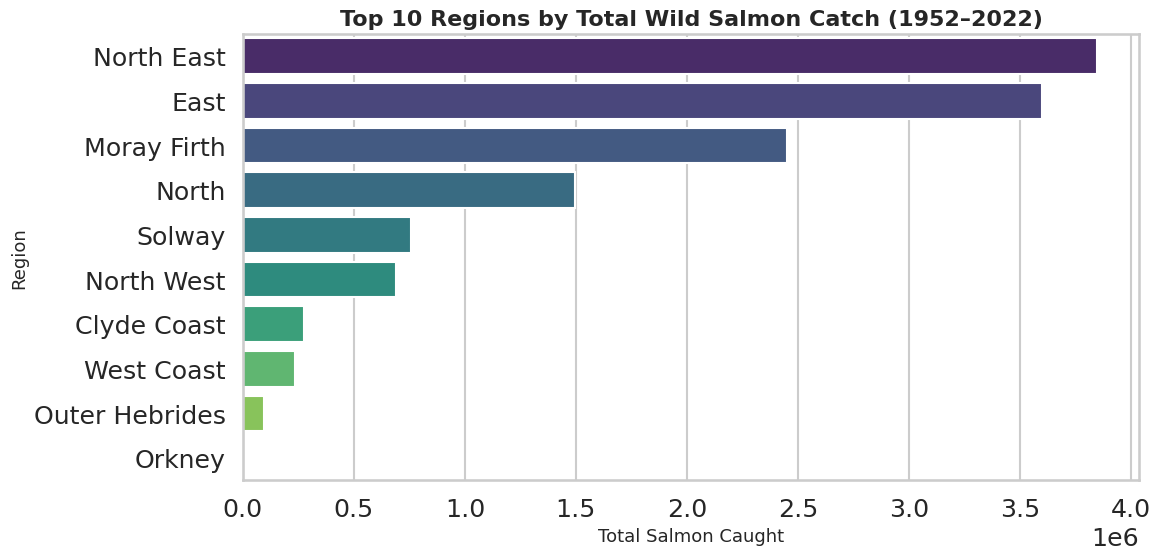

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate total wild salmon per row
df['Wild Total'] = df['Wild MSW number'] + df['Wild 1SW number']

# Step 2: Group by Region and sum
grouped = df.groupby('Region', as_index=False)['Wild Total'].sum()

# Step 3: Sort and take Top 10 Regions
top10 = grouped.sort_values('Wild Total', ascending=False).head(10)

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

sns.barplot(
    data=top10,
    x='Wild Total',
    y='Region',
    palette="viridis"
)

plt.title("Top 10 Regions by Total Wild Salmon Catch (1952–2022)", fontsize=16, fontweight='bold')
plt.xlabel("Total Salmon Caught", fontsize=13)
plt.ylabel("Region", fontsize=13)

plt.tight_layout()
plt.show()


/tmp/ipython-input-10-73458626.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


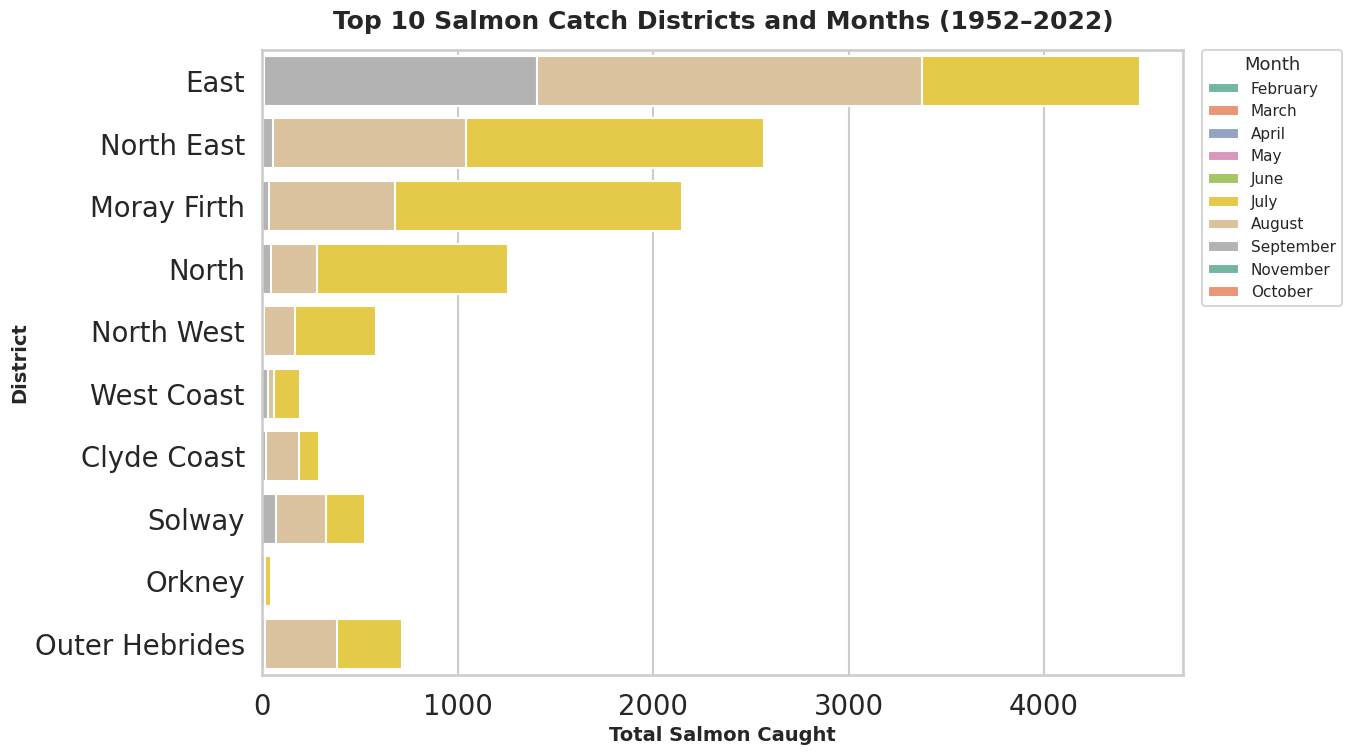

In [10]:
df['Wild Total'] = df['Wild MSW number'] + df['Wild 1SW number']

# # Group by District and Month
# grouped = df.groupby(['District', 'Month'])['Wild Total'].sum().reset_index()

# # Get top 10 District-Month combinations
# top10 = grouped.sort_values('Wild Total', ascending=False).head(10)

# Plot
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)  # Bigger fonts for presentations

# Create the figure
plt.figure(figsize=(14, 8))

# Plot with a beautiful color palette
sns.barplot(
    data=df,
    x='Wild Total',
    y='Region',
    hue='Month',
    dodge=False,
    palette="Set2",  # Try 'Set2', 'Spectral', 'coolwarm', or 'tab10' for vibrant colors
    ci=None
)

# Customize the title and labels
plt.title("Top 10 Salmon Catch Districts and Months (1952–2022)", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Total Salmon Caught", fontsize=14, fontweight='bold')
plt.ylabel("District", fontsize=14, fontweight='bold')

# Improve legend placement and label
plt.legend(
    title="Month",
    title_fontsize='13',
    fontsize='11',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

# Improve layout
plt.tight_layout()
plt.show()

In [11]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Filter only salmon and sea trout totals
df['Sea Trout Total'] = df['Sea trout number'].fillna(0)
df_melted = df.melt(
    id_vars=['Region', 'Month'],
    value_vars=['Wild Total', 'Sea Trout Total'],
    var_name='Species',
    value_name='Catch Total'
)

# Filter to top 10 districts or as needed
top_regions = df.groupby('Region')['Wild Total'].sum().nlargest(10).index
df_melted = df_melted[df_melted['Region'].isin(top_regions)]



<Figure size 1400x800 with 0 Axes>

/tmp/ipython-input-12-3751432668.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-12-3751432668.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


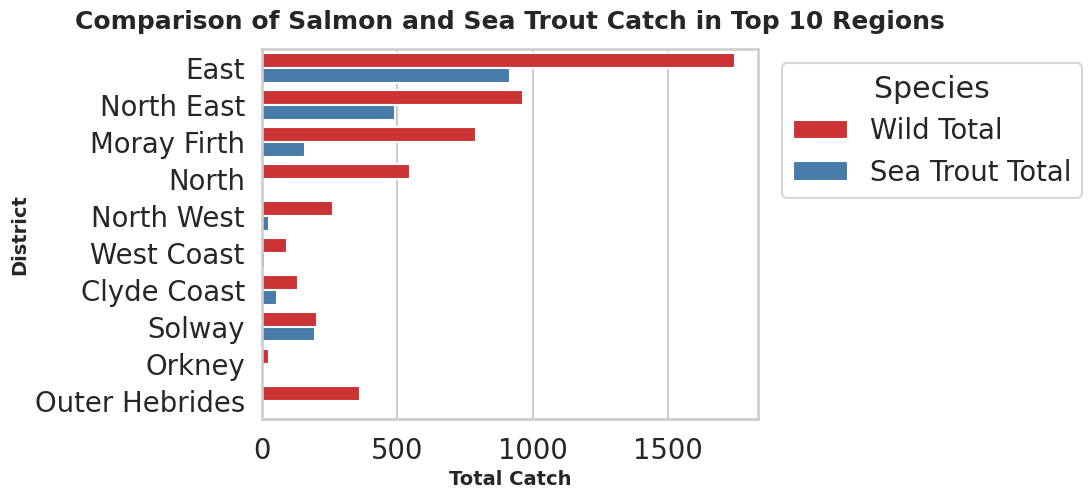

In [12]:
# Plot
sns.barplot(
    data=df_melted,
    x='Catch Total',
    y='Region',
    hue='Species',
    palette='Set1',
    ci=None
)

plt.title("Comparison of Salmon and Sea Trout Catch in Top 10 Regions", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Total Catch", fontsize=14, fontweight='bold')
plt.ylabel("District", fontsize=14, fontweight='bold')
plt.legend(title="Species", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
# Avoid division by zero
df = df[df['Wild Total'] > 0]

# Add average weight per fish
df['Average Weight'] = df['Wild Total weight'] / df['Wild Total']

# Group by Region and compute total number, average weight
summary = df.groupby('Region').agg(
    Total_Salmon=('Wild Total', 'sum'),
    Average_Weight=('Average Weight', 'mean')
).reset_index()

# Sort by number and size descending (largest first)
summary_sorted = summary.sort_values(
    by=['Total_Salmon', 'Average_Weight'],
    ascending=[False, False]  # Largest to smallest
).reset_index(drop=True)  # Reset index after sorting

# Show top 10 with correct index
print(summary_sorted.head(10))

           Region  Total_Salmon  Average_Weight
0      North East     3846149.0        3.781636
1            East     3599663.0        4.058685
2     Moray Firth     2450910.0        3.886505
3           North     1496961.0        3.475835
4          Solway      759264.0        3.688438
5      North West      687959.0        3.411605
6     Clyde Coast      277421.0        3.461857
7      West Coast      236091.0        3.523174
8  Outer Hebrides       96136.0        3.016941
9          Orkney          77.0        3.323162


/tmp/ipython-input-13-3250904248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Average Weight'] = df['Wild Total weight'] / df['Wild Total']


In [14]:
# Select top 10 rows
top10 = summary_sorted.head(10)

# Format table with Pandas styling
styled_table = (
    top10.style
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt'), ('background-color', '#4B8BBE'), ('color', 'white'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '13pt'), ('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#E6F2FF')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#D1E7FF')]}
    ])
    .format({
        'Total_Salmon': '{:,.0f}',        # No decimals, comma as thousands separator
        'Total_Weight': '{:,.1f}',        # One decimal place
        'Average_Weight': '{:.2f}'        # Two decimal places
    })
    .set_caption("Top 10 Regions by Salmon Catch and Average Weight")
)

# Display styled table
styled_table

,Region,Total_Salmon,Average_Weight
0,North East,"3,846,149",3.78
1,East,"3,599,663",4.06
2,Moray Firth,"2,450,910",3.89
3,North,"1,496,961",3.48
4,Solway,"759,264",3.69
5,North West,"687,959",3.41
6,Clyde Coast,"277,421",3.46
7,West Coast,"236,091",3.52
8,Outer Hebrides,"96,136",3.02
9,Orkney,77,3.32


/tmp/ipython-input-15-1397354471.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


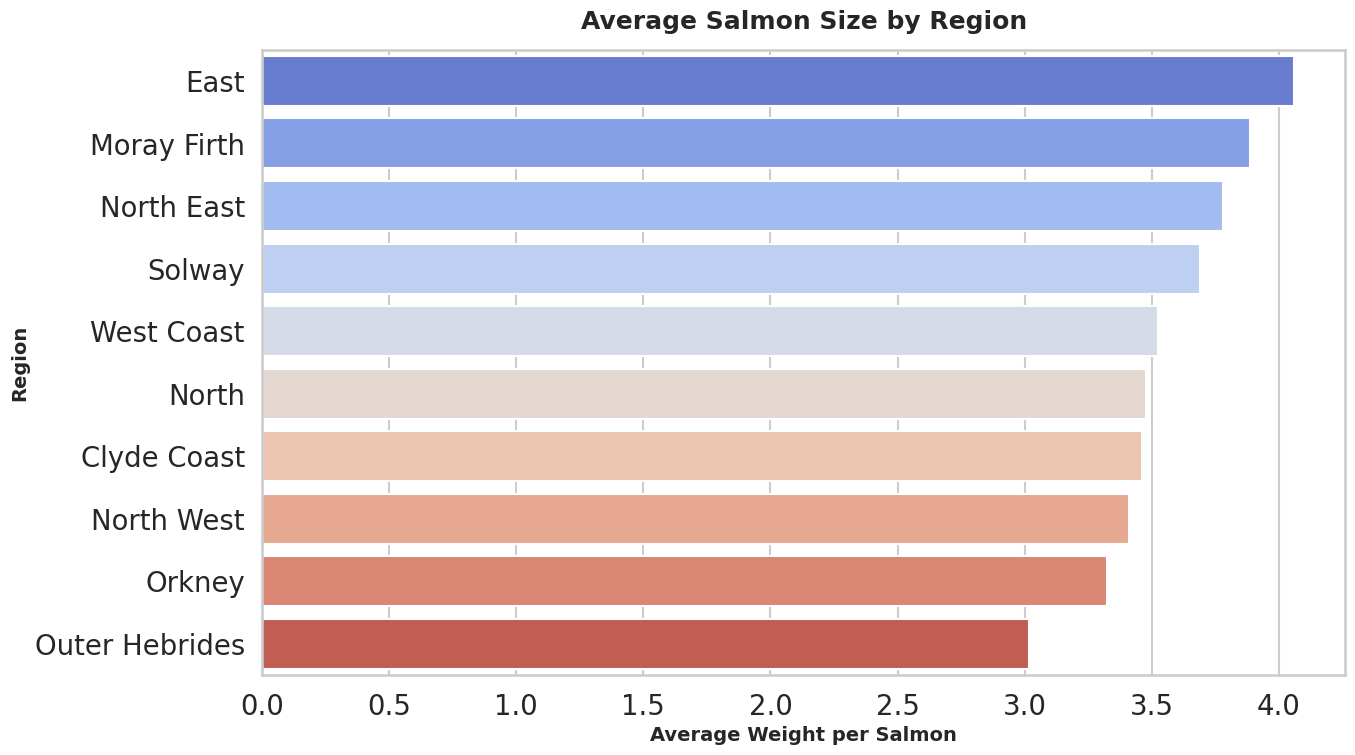

In [15]:
# Calculate average weight per salmon, excluding zero totals to avoid division errors
df_filtered = df[df['Wild Total'] > 0].copy()
df_filtered['Average Weight'] = df_filtered['Wild Total weight'] / df_filtered['Wild Total']

# Aggregate average weight by region
avg_weight_by_region = df_filtered.groupby('Region')['Average Weight'].mean().reset_index()

# Sort regions by average weight descending
avg_weight_by_region = avg_weight_by_region.sort_values(by='Average Weight', ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

sns.barplot(
    data=avg_weight_by_region,
    x='Average Weight',
    y='Region',
    palette='coolwarm'
)

plt.title("Average Salmon Size by Region", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Average Weight per Salmon", fontsize=14, fontweight='bold')
plt.ylabel("Region", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [16]:
# Forecast Wild Salmon Count (next 5 years)
ts = agg_df.set_index('Year')['Wild Total'].sort_index()
model = ExponentialSmoothing(ts, trend='add', seasonal=None).fit()
forecast = model.forecast(5).clip(lower=0)
forecast_years = list(range(ts.index[-1] + 1, ts.index[-1] + 6))

# Trendline for Count
z = np.polyfit(ts.index, ts.values, 1)
p = np.poly1d(z)
trendline = p(ts.index)

# Forecast Wild Salmon Weight (next 5 years)
ts_weight = agg_df.set_index('Year')['Wild Total weight'].sort_index()
weight_model = ExponentialSmoothing(ts_weight, trend='add', seasonal=None).fit()
weight_forecast = weight_model.forecast(5).clip(lower=0)
weight_forecast_years = list(range(ts_weight.index[-1] + 1, ts_weight.index[-1] + 6))

# Trendline for Weight
z_w = np.polyfit(ts_weight.index, ts_weight.values, 1)
p_w = np.poly1d(z_w)
weight_trendline = p_w(ts_weight.index)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

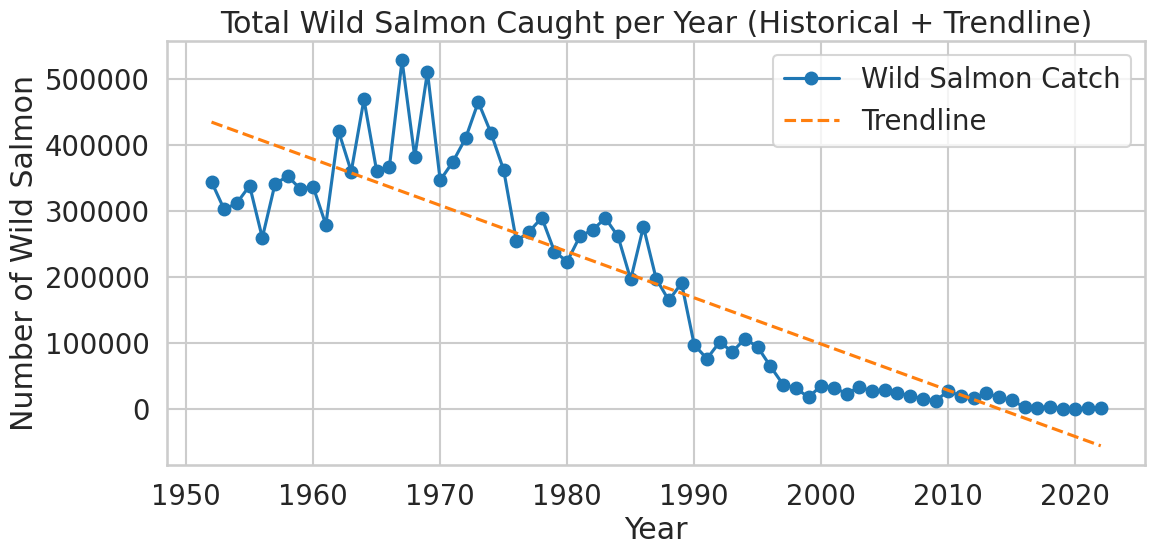

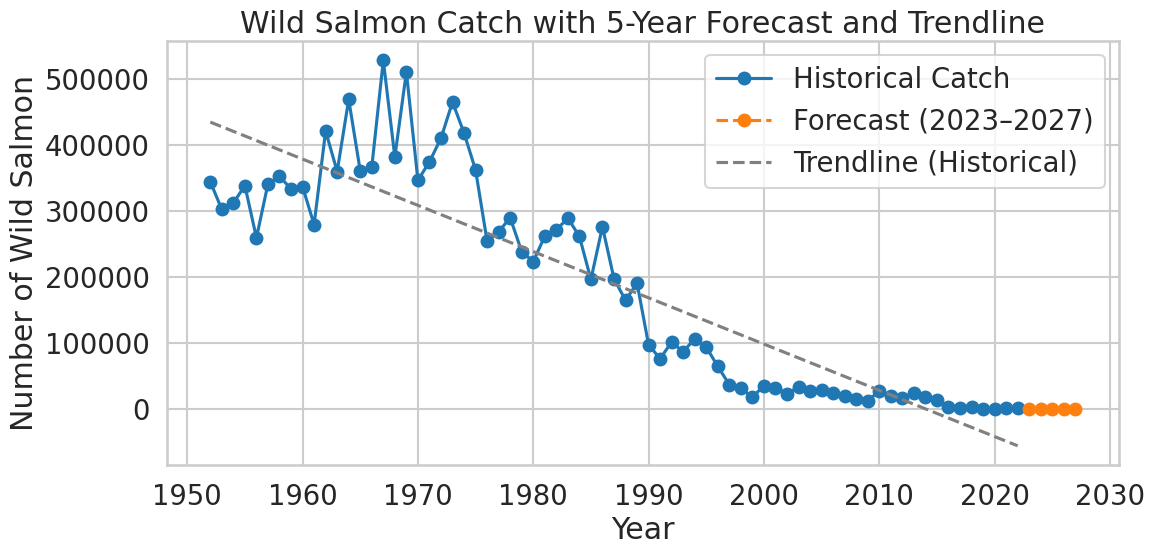

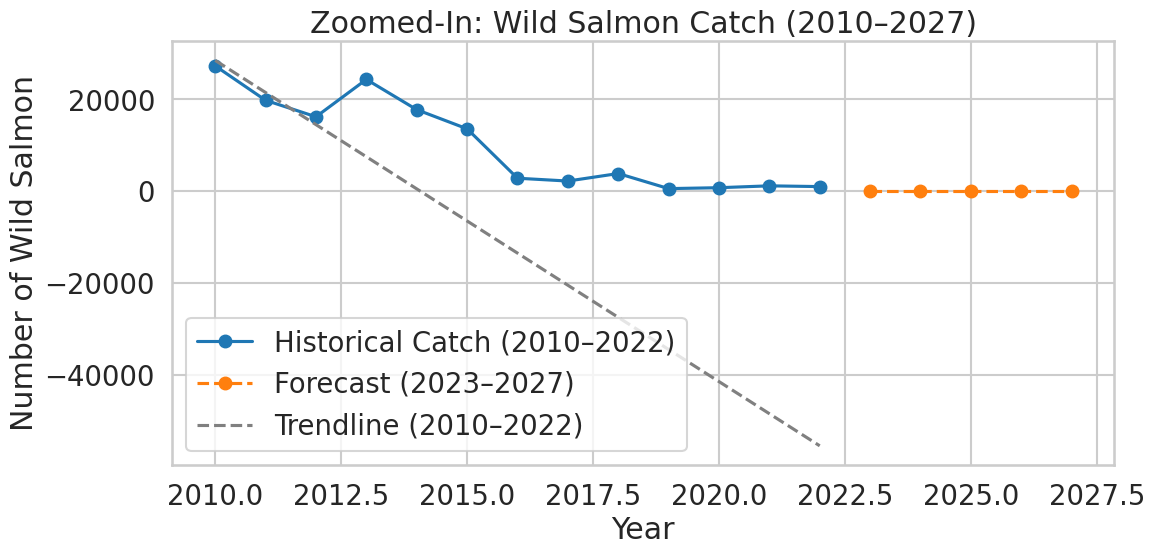

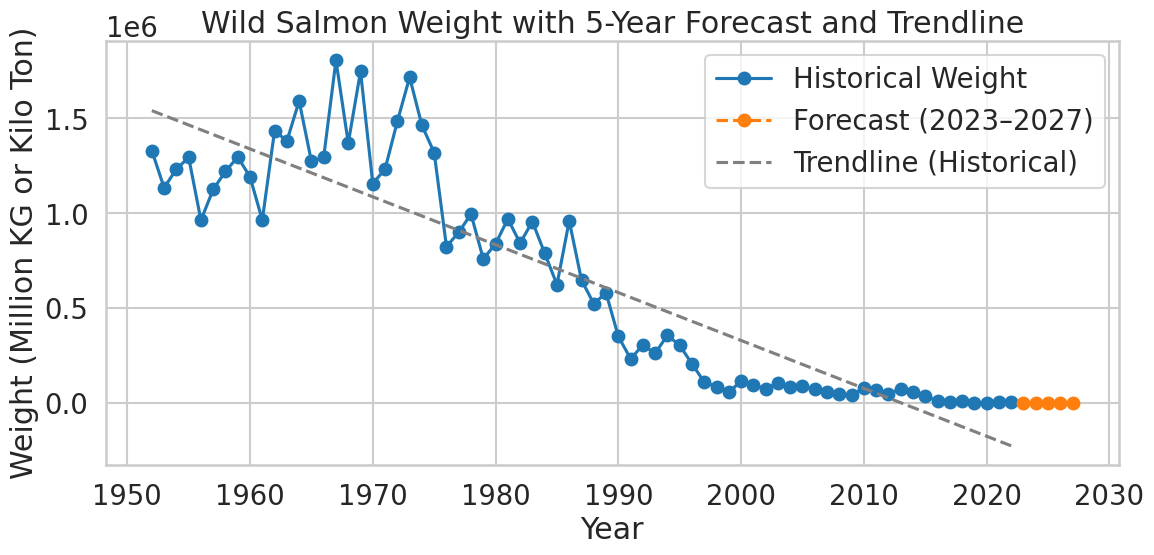

In [17]:
# Chart 1: Historical Wild Salmon Catch + Trendline
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, marker='o', label='Wild Salmon Catch')
plt.plot(ts.index, trendline, linestyle='--', label='Trendline')
plt.title('Total Wild Salmon Caught per Year (Historical + Trendline)')
plt.xlabel('Year')
plt.ylabel('Number of Wild Salmon')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Chart 2: Historical + Forecasted Wild Salmon Catch + Trendline
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, marker='o', label='Historical Catch')
plt.plot(forecast_years, forecast.values, marker='o', linestyle='--', label='Forecast (2023–2027)')
plt.plot(ts.index, trendline, linestyle='--', color='gray', label='Trendline (Historical)')
plt.title('Wild Salmon Catch with 5-Year Forecast and Trendline')
plt.xlabel('Year')
plt.ylabel('Number of Wild Salmon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Chart 3: Zoom-In (2010 to Present)
ts_recent = ts[ts.index >= 2010]
trendline_recent = p(ts_recent.index)
plt.figure(figsize=(12, 6))
plt.plot(ts_recent.index, ts_recent.values, marker='o', label='Historical Catch (2010–2022)')
plt.plot(forecast_years, forecast.values, marker='o', linestyle='--', label='Forecast (2023–2027)')
plt.plot(ts_recent.index, trendline_recent, linestyle='--', color='gray', label='Trendline (2010–2022)')
plt.title('Zoomed-In: Wild Salmon Catch (2010–2027)')
plt.xlabel('Year')
plt.ylabel('Number of Wild Salmon')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Chart 4: Wild Salmon Weight (Historical + Forecast + Trendline)
plt.figure(figsize=(12, 6))
plt.plot(ts_weight.index, ts_weight.values, marker='o', label='Historical Weight')
plt.plot(weight_forecast_years, weight_forecast.values, marker='o', linestyle='--', label='Forecast (2023–2027)')
plt.plot(ts_weight.index, weight_trendline, linestyle='--', color='gray', label='Trendline (Historical)')
plt.title('Wild Salmon Weight with 5-Year Forecast and Trendline')
plt.xlabel('Year')
plt.ylabel('Weight (Million KG or Kilo Ton)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


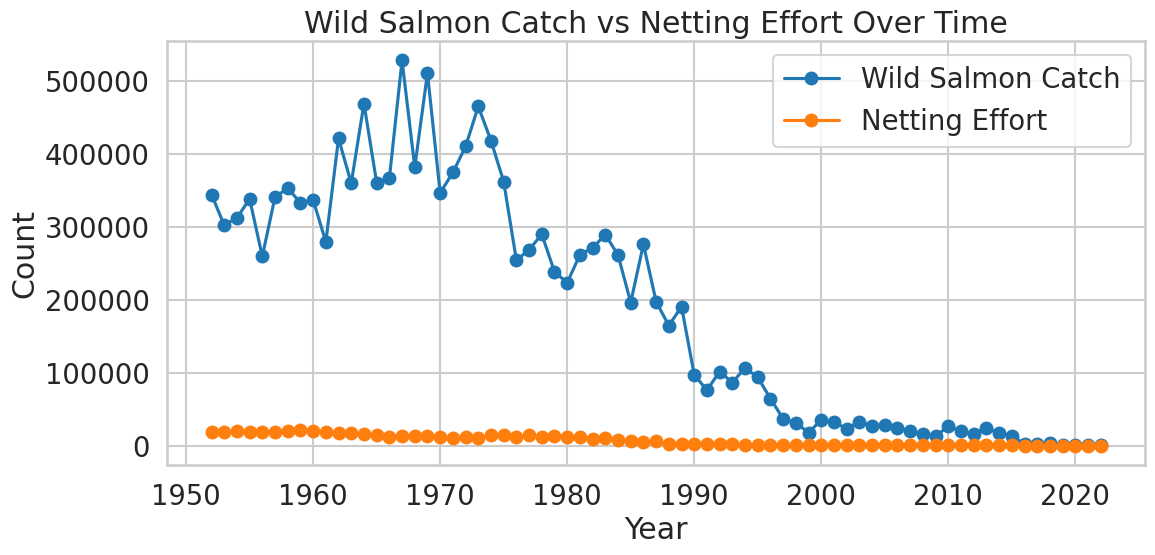

In [18]:
# ✅ STEP 7: Wild Salmon Catch vs Netting Effort
plt.figure(figsize=(12, 6))
plt.plot(agg_df['Year'], agg_df['Wild Total'], label='Wild Salmon Catch', marker='o')
plt.plot(agg_df['Year'], agg_df['Netting effort'], label='Netting Effort', marker='o')
plt.title('Wild Salmon Catch vs Netting Effort Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

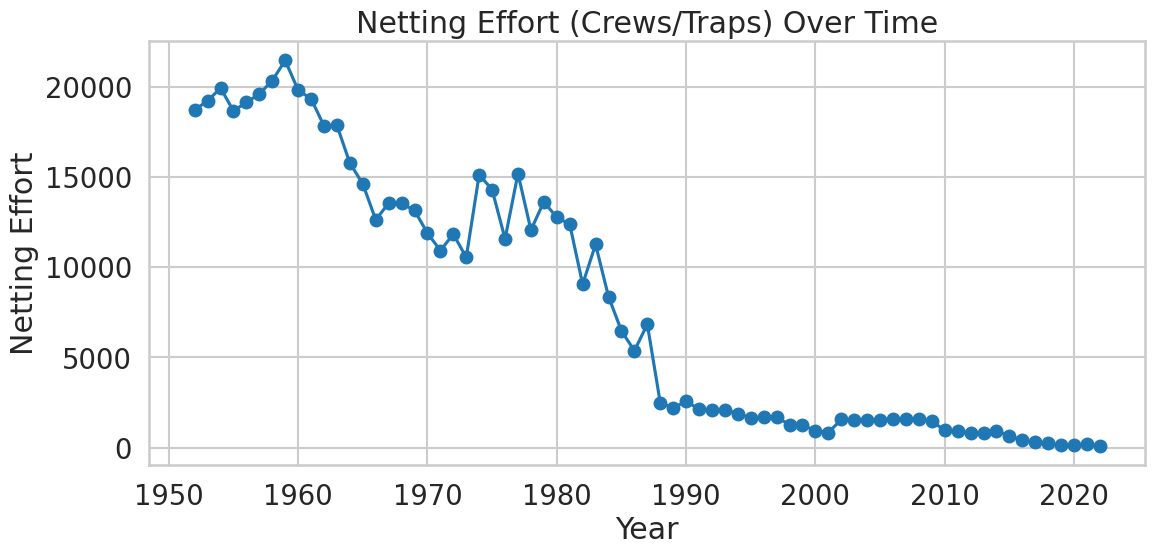

In [19]:
# ✅ STEP 8: Netting Effort Over Time (Separate Chart)
plt.figure(figsize=(12, 6))
plt.plot(agg_df['Year'], agg_df['Netting effort'], marker='o', label='Netting Effort')
plt.title('Netting Effort (Crews/Traps) Over Time')
plt.xlabel('Year')
plt.ylabel('Netting Effort')
plt.grid(True)
plt.tight_layout()
plt.show()


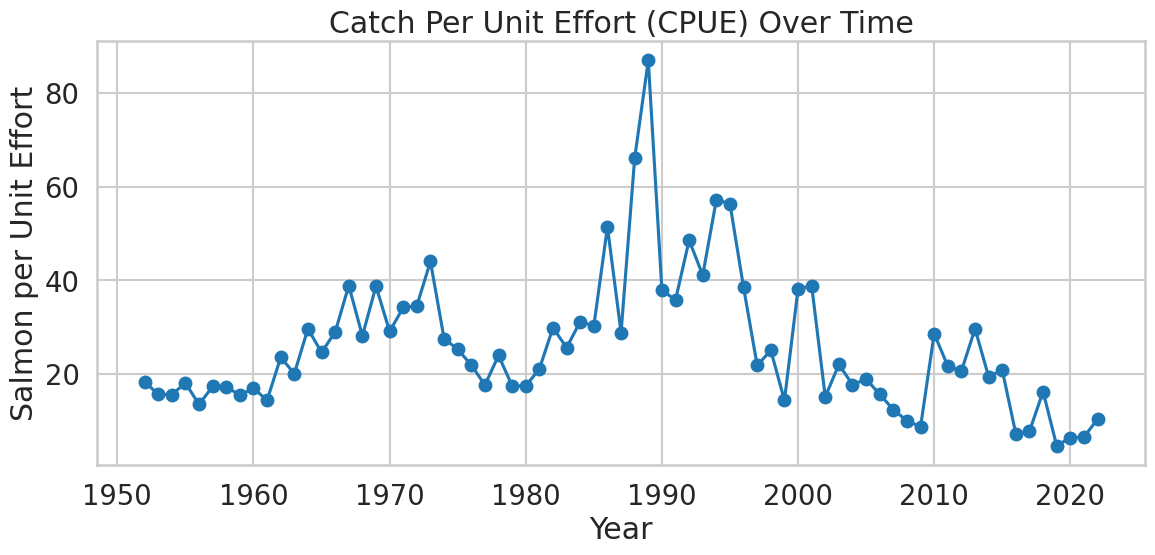

In [20]:
# ✅ STEP 9: CPUE Over Time
plt.figure(figsize=(12, 6))
plt.plot(agg_df['Year'], agg_df['CPUE'], label='CPUE (Wild per Crew/Trap)', marker='o')
plt.title('Catch Per Unit Effort (CPUE) Over Time')
plt.xlabel('Year')
plt.ylabel('Salmon per Unit Effort')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# ✅ STEP 1: Install Plotly if needed
!pip install plotly --quiet

# ✅ STEP 2: Import Libraries
import pandas as pd
import plotly.express as px

# ✅ STEP 3: Aggregate Catch by Region
region_df = df.copy()
region_df['Wild Total'] = region_df['Wild MSW number'].fillna(0) + region_df['Wild 1SW number'].fillna(0)
region_summary = region_df.groupby('Region')['Wild Total'].sum().reset_index()

# ✅ STEP 4: Add Latitude/Longitude (Example Estimates for Scottish Salmon Regions)
region_coords = {
    'Clyde Coast':      {'lat': 55.9, 'lon': -4.9},
    'East':             {'lat': 56.0, 'lon': -2.8},
    'Moray Firth':      {'lat': 57.7, 'lon': -3.5},
    'North':            {'lat': 58.3, 'lon': -4.3},
    'North East':       {'lat': 57.1, 'lon': -2.2},
    'North West':       {'lat': 58.0, 'lon': -5.3},
    'Orkney':           {'lat': 59.0, 'lon': -3.0},
    'Outer Hebrides':   {'lat': 57.8, 'lon': -6.2},
    'Solway':           {'lat': 54.9, 'lon': -3.6},
    'West Coast':       {'lat': 56.8, 'lon': -5.5}
}

# Merge coordinates into the summary dataframe
region_summary['lat'] = region_summary['Region'].map(lambda x: region_coords.get(x, {}).get('lat'))
region_summary['lon'] = region_summary['Region'].map(lambda x: region_coords.get(x, {}).get('lon'))

# ✅ STEP 5: Filter out missing coords (just in case)
region_summary = region_summary.dropna(subset=['lat', 'lon'])

# ✅ STEP 6: Plot Geo Chart using Plotly
fig = px.scatter_geo(
    region_summary,
    lat='lat',
    lon='lon',
    text='Region',
    size='Wild Total',
    color='Wild Total',
    color_continuous_scale='Blues',
    title='Total Wild Salmon Catch by Region (1952–2022)',
    projection='natural earth',
)

fig.update_layout(
    geo=dict(
        projection_type="natural earth",
        center={"lat": 56.5, "lon": -4},  # Centered on Scotland
        lonaxis_range=[-8, 2],            # Longitude bounds for UK
        lataxis_range=[54, 61],           # Latitude bounds for Scotland
        showland=True,
        landcolor="lightgrey",
    )
)
fig.show()


In [22]:
# ✅ Make sure Plotly is installed
!pip install plotly --quiet

# ✅ Import libraries
import pandas as pd
import plotly.express as px

# ✅ Region coordinates (centered on Scotland)
region_coords = {
    'Clyde Coast':      {'lat': 55.9, 'lon': -4.9},
    'East':             {'lat': 56.0, 'lon': -2.8},
    'Moray Firth':      {'lat': 57.7, 'lon': -3.5},
    'North':            {'lat': 58.3, 'lon': -4.3},
    'North East':       {'lat': 57.1, 'lon': -2.2},
    'North West':       {'lat': 58.0, 'lon': -5.3},
    'Orkney':           {'lat': 59.0, 'lon': -3.0},
    'Outer Hebrides':   {'lat': 57.8, 'lon': -6.2},
    'Solway':           {'lat': 54.9, 'lon': -3.6},
    'West Coast':       {'lat': 56.8, 'lon': -5.5}
}

# ✅ Aggregate Wild Total by Region
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
region_summary = df.groupby('Region')['Wild Total'].sum().reset_index()

# ✅ Add coordinates
region_summary['lat'] = region_summary['Region'].map(lambda x: region_coords.get(x, {}).get('lat'))
region_summary['lon'] = region_summary['Region'].map(lambda x: region_coords.get(x, {}).get('lon'))
region_summary = region_summary.dropna(subset=['lat', 'lon'])

# ✅ Build Map with Better Dot Visibility
fig = px.scatter_mapbox(
    region_summary,
    lat='lat',
    lon='lon',
    text='Region',
    hover_name='Region',
    size='Wild Total',
    color='Wild Total',
    size_max=50,                       # Increased max size
    color_continuous_scale='YlGnBu',
    opacity=0.85,                      # More visible over basemap
    zoom=5,
    height=600,
    title='Total Wild Salmon Catch by Region (with Enhanced Visibility)'
)

# Use open-access map style (no token required)
fig.update_layout(
    mapbox_style='open-street-map',
    mapbox_center={"lat": 57.2, "lon": -4},
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()


In [23]:
# Convert farm tonnes to kg
farm_df['Farm Weight (kg)'] = farm_df['Tonnes'] * 1000

# Align both datasets
farm_weight_series = farm_df.set_index('Year')['Farm Weight (kg)']
common_years = ts_weight.index.intersection(farm_weight_series.index)
aligned_farm_weight = farm_weight_series.loc[common_years]

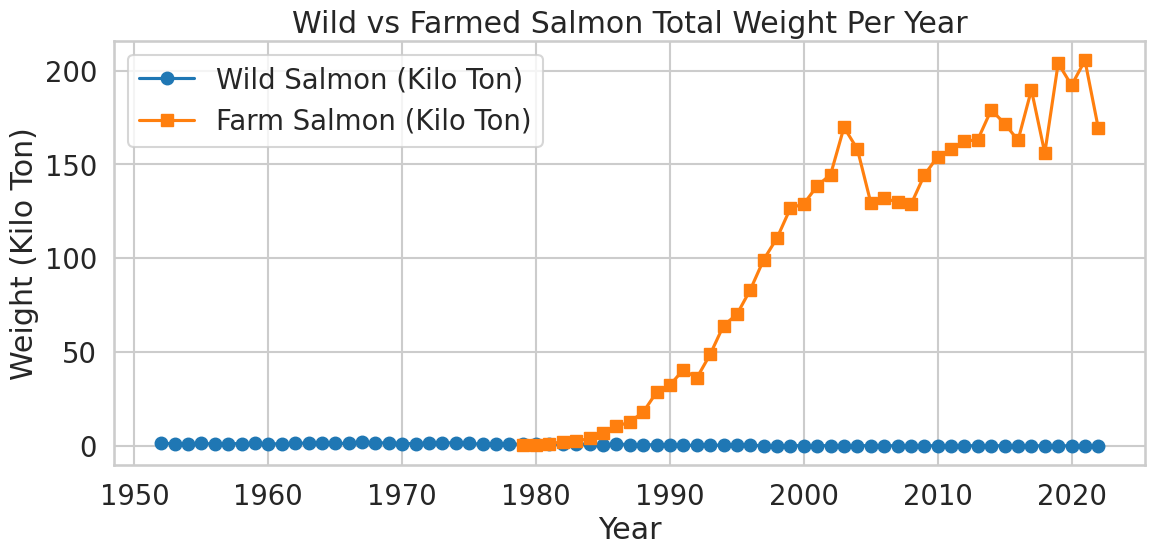

In [24]:
# Plot Wild vs Farm Total Weight Per Year
plt.figure(figsize=(12, 6))
plt.plot(ts_weight.index, ts_weight.values / 1000000 , marker='o', label='Wild Salmon (Kilo Ton)')
plt.plot(aligned_farm_weight.index, aligned_farm_weight.values / 1000000, marker='s', linestyle='-', label='Farm Salmon (Kilo Ton)')

plt.title('Wild vs Farmed Salmon Total Weight Per Year')
plt.xlabel('Year')
plt.ylabel('Weight (Kilo Ton)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Clustering

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [26]:
# Clean necessary columns
df = df.dropna(subset=['Year', 'Region'])
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
df['Wild Weight'] = df['Wild MSW weight (kg)'].fillna(0) + df['Wild 1SW weight (kg)'].fillna(0)
df['CPUE'] = df['Wild Total'] / df['Netting effort'].replace(0, np.nan)

# Aggregate by Region
region_df = df.groupby('Region').agg({
    'Wild Total': 'mean',
    'Wild Weight': 'mean',
    'Netting effort': 'mean',
    'CPUE': 'mean'
}).dropna().reset_index()

In [27]:
# Select features to cluster
features = ['Wild Total', 'Wild Weight', 'Netting effort', 'CPUE']
X = region_df[features]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans (try 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
region_df['Cluster'] = kmeans.fit_predict(X_scaled)

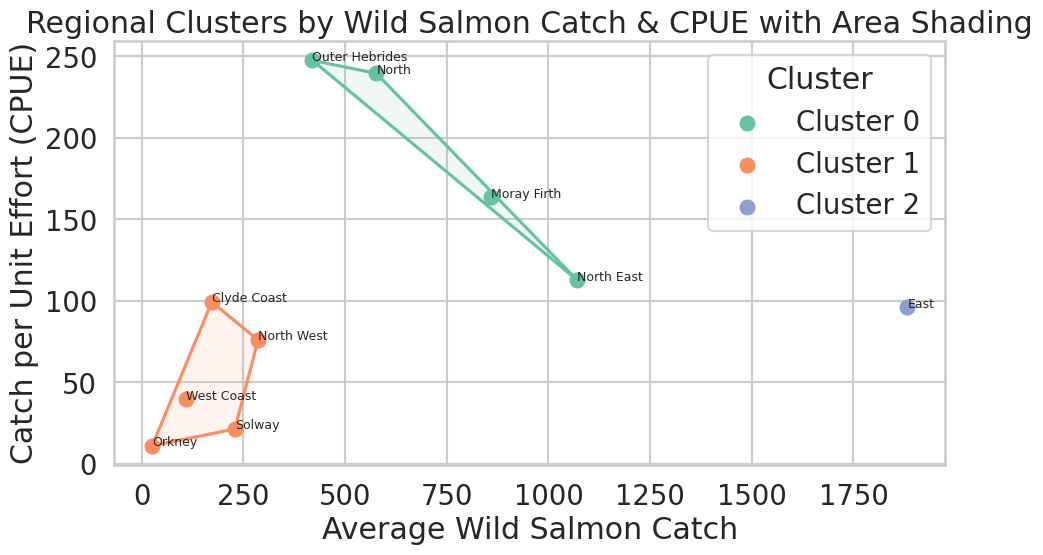

,Region,Wild Total,Wild Weight,Netting effort,CPUE,Cluster
3,North,576.641371,1804.352042,5.060478,239.647430,0
2,Moray Firth,858.462347,2906.373100,12.900876,163.514274,0
7,Outer Hebrides,419.807860,1245.934498,1.524017,247.577193,0
4,North East,1071.350696,3676.631448,20.425766,112.598412,0
5,North West,286.053638,870.671393,3.856549,75.987240,1
0,Clyde Coast,172.204221,561.275978,2.991620,99.390345,1
6,Orkney,25.666667,83.633333,2.166667,11.111111,1
8,Solway,229.038914,771.774238,116.329412,21.442347,1
9,West Coast,109.758717,350.112692,2.218503,39.617618,1
1,East,1882.668933,7300.613128,12.986402,96.026614,2


In [28]:
from scipy.spatial import ConvexHull

# Create plot
plt.figure(figsize=(10, 6))
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Plot each cluster with convex hull
for cluster in sorted(region_df['Cluster'].unique()):
    cluster_data = region_df[region_df['Cluster'] == cluster]
    x = cluster_data['Wild Total'].values
    y = cluster_data['CPUE'].values

    # Scatter points
    plt.scatter(x, y, s=100, label=f'Cluster {cluster}', color=colors[cluster])

    # Plot convex hull (if enough points)
    if len(cluster_data) >= 3:
        points = np.column_stack((x, y))
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], color=colors[cluster])
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], alpha=0.1, color=colors[cluster])

    # Label regions
    for _, row in cluster_data.iterrows():
        plt.text(row['Wild Total'], row['CPUE'], row['Region'], fontsize=9)

# Plot formatting
plt.title('Regional Clusters by Wild Salmon Catch & CPUE with Area Shading')
plt.xlabel('Average Wild Salmon Catch')
plt.ylabel('Catch per Unit Effort (CPUE)')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# View cluster assignment
region_df.sort_values(by='Cluster')

# Seasonal Salmon Catch by Month

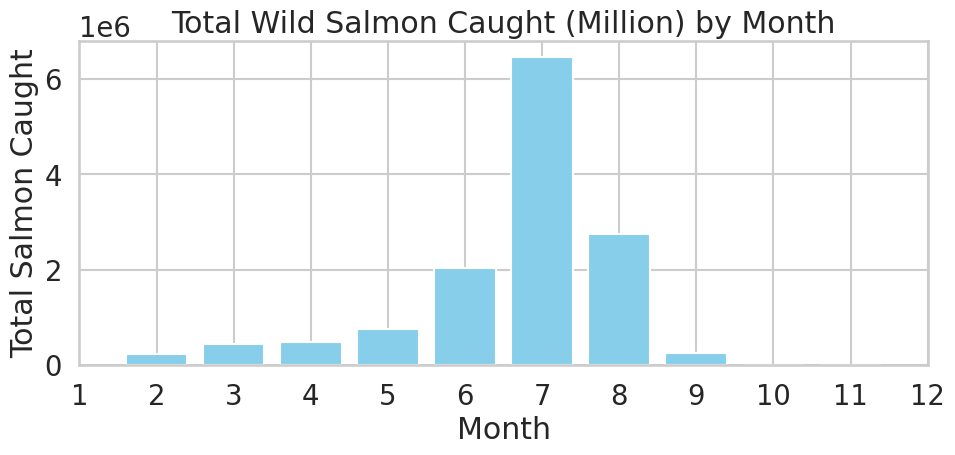

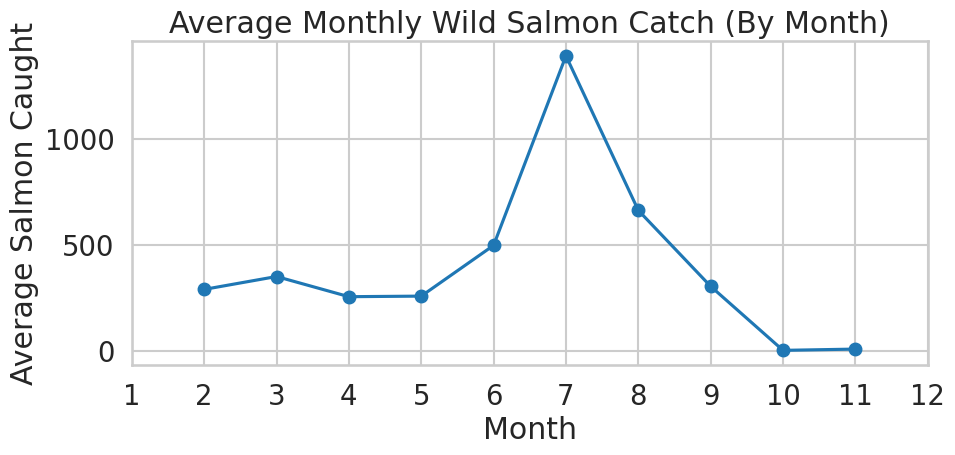

In [29]:
# Prepare relevant columns
df['Month number'] = pd.to_numeric(df['Month number'], errors='coerce')
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)

# Group by month
monthly_catch = df.groupby('Month number')['Wild Total'].agg(['sum', 'mean']).reset_index()
monthly_catch = monthly_catch.sort_values('Month number')

# Plot Total Catch per Month
plt.figure(figsize=(10, 5))
plt.bar(monthly_catch['Month number'], monthly_catch['sum'], color='skyblue')
plt.title('Total Wild Salmon Caught (Million) by Month')
plt.xlabel('Month')
plt.ylabel('Total Salmon Caught')
plt.xticks(range(1, 13))
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot Average Catch per Month
plt.figure(figsize=(10, 5))
plt.plot(monthly_catch['Month number'], monthly_catch['mean'], marker='o')
plt.title('Average Monthly Wild Salmon Catch (By Month)')
plt.xlabel('Month')
plt.ylabel('Average Salmon Caught')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-1928489843.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




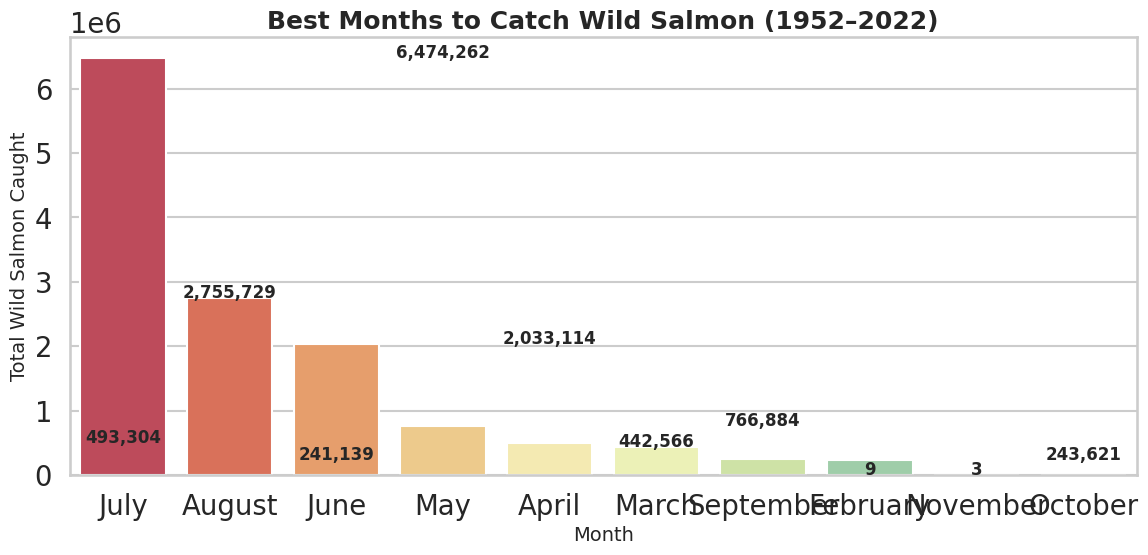

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate total Wild salmon
df['Wild Total'] = df['Wild MSW number'] + df['Wild 1SW number']

# Group by Month only
month_summary = df.groupby('Month')['Wild Total'].sum().reset_index()

# Sort months by total salmon caught (descending)
month_summary = month_summary.sort_values('Wild Total', ascending=False)

# Plot
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=month_summary,
    x='Month',
    y='Wild Total',
    palette='Spectral'
)

# Add values on top of bars
for i, row in month_summary.iterrows():
    barplot.text(i, row['Wild Total'] + 500, f"{int(row['Wild Total']):,}",
                 ha='center', fontsize=12, fontweight='bold')

# Titles and labels
plt.title("Best Months to Catch Wild Salmon (1952–2022)", fontsize=18, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Wild Salmon Caught", fontsize=14)

plt.tight_layout()
plt.show()


In [31]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 1. Calculate total Wild salmon
# df['Wild Total'] = df['Wild MSW number'] + df['Wild 1SW number']

# # 2. Group by District and Month
# grouped = df.groupby(['Month', 'District'])['Wild Total'].sum().reset_index()

# # 3. For each Month, get the District with the highest catch
# best_locations = grouped.sort_values('Wild Total', ascending=False).groupby('Month').first().reset_index()

# # 4. Plot
# sns.set_style("whitegrid")
# sns.set_context("talk", font_scale=1.1)

# plt.figure(figsize=(12, 6))
# barplot = sns.barplot(
#     data=best_locations,
#     x='Month',
#     y='Wild Total',
#     hue='District',
#     dodge=False,
#     palette='Set2'
# )

# # Add values
# for i, row in best_locations.iterrows():
#     barplot.text(i, row['Wild Total'] + 500, row['District'],
#                  ha='center', fontsize=11, fontweight='bold', rotation=30)

# # Title and labels
# plt.title("Best District to Catch Wild Salmon by Month", fontsize=16, fontweight='bold')
# plt.xlabel("Month", fontsize=13)
# plt.ylabel("Total Wild Salmon Caught", fontsize=13)

# plt.legend([],[], frameon=False)  # Hide legend to avoid clutter

# plt.tight_layout()
# plt.show()


/tmp/ipython-input-32-2792417829.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-32-2792417829.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



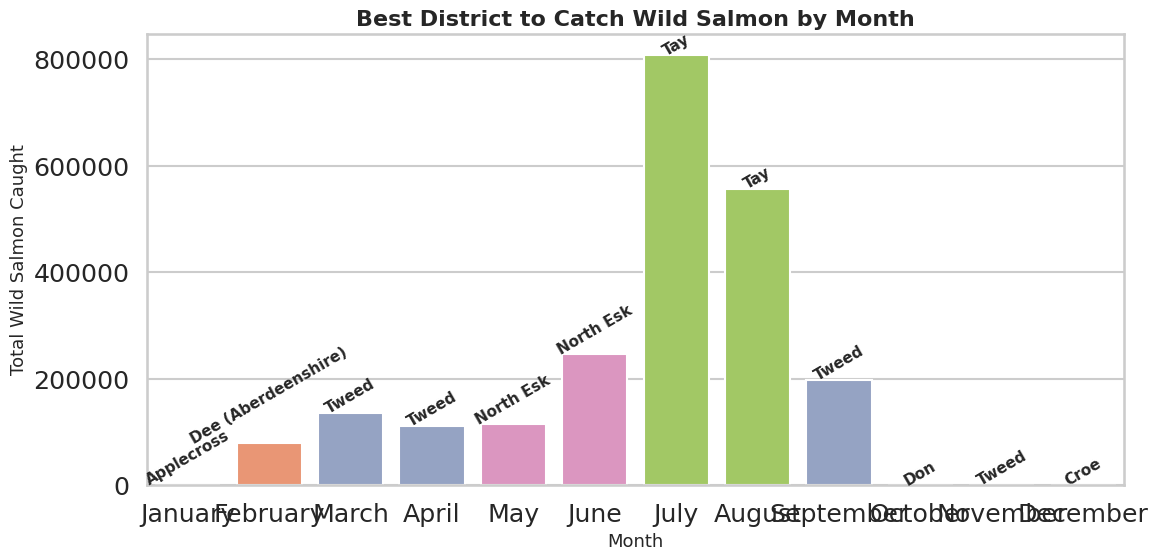

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate total Wild salmon
df['Wild Total'] = df['Wild MSW number'] + df['Wild 1SW number']

# Ensure Month is consistent (e.g., capitalized full names)
df['Month'] = df['Month'].str.strip().str.capitalize()

# Set calendar month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Group by Month and District
grouped = df.groupby(['Month', 'District'])['Wild Total'].sum().reset_index()

# Get best district for each month
best_locations = grouped.sort_values('Wild Total', ascending=False).groupby('Month').first().reset_index()

# Plot
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=best_locations.sort_values('Month'),
    x='Month',
    y='Wild Total',
    hue='District',
    dodge=False,
    palette='Set2'
)

# Add labels
for i, row in best_locations.iterrows():
    barplot.text(i, row['Wild Total'] + 500, row['District'],
                 ha='center', fontsize=11, fontweight='bold', rotation=30)

# Titles and labels
plt.title("Best District to Catch Wild Salmon by Month", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=13)
plt.ylabel("Total Wild Salmon Caught", fontsize=13)

# Hide legend (district shown above bars)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()


/tmp/ipython-input-47-853944123.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-47-853944123.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



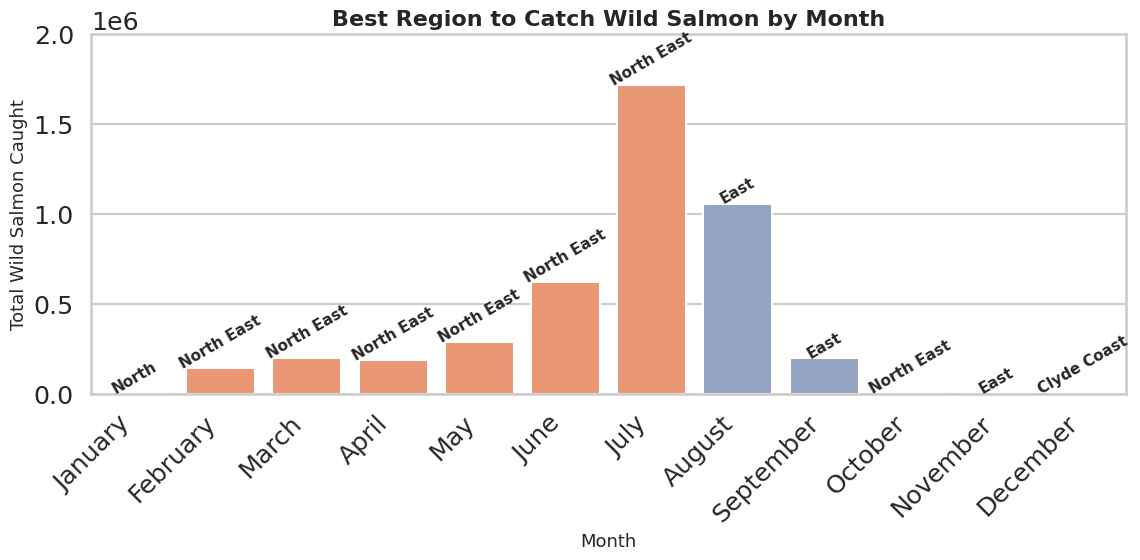

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Calculate total Wild salmon
df['Wild Total'] = df['Wild MSW number'] + df['Wild 1SW number']

# 2. Clean month values and define order
df['Month'] = df['Month'].str.strip().str.capitalize()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# 3. Group by Month and Region
grouped = df.groupby(['Month', 'Region'])['Wild Total'].sum().reset_index()

# 4. For each Month, get the Region with the highest total catch
best_regions = (
    grouped
    .sort_values('Wild Total', ascending=False)
    .groupby('Month')
    .first()
    .reset_index()
    .sort_values('Month')
)

# 5. Plot
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=best_regions,
    x='Month',
    y='Wild Total',
    hue='Region',
    dodge=False,
    palette='Set2'
)

# Add region labels on top of bars
for i, row in best_regions.iterrows():
    barplot.text(i, row['Wild Total'] + 500, row['Region'],
                 ha='center', fontsize=11, fontweight='bold', rotation=30)

# Customize plot
plt.title("Best Region to Catch Wild Salmon by Month", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=13)
plt.ylim(0, 2e6)
plt.ylabel("Total Wild Salmon Caught", fontsize=13)
plt.xticks(rotation=45, ha="right")
plt.legend([],[], frameon=False)  # Hide legend

plt.tight_layout()
plt.show()


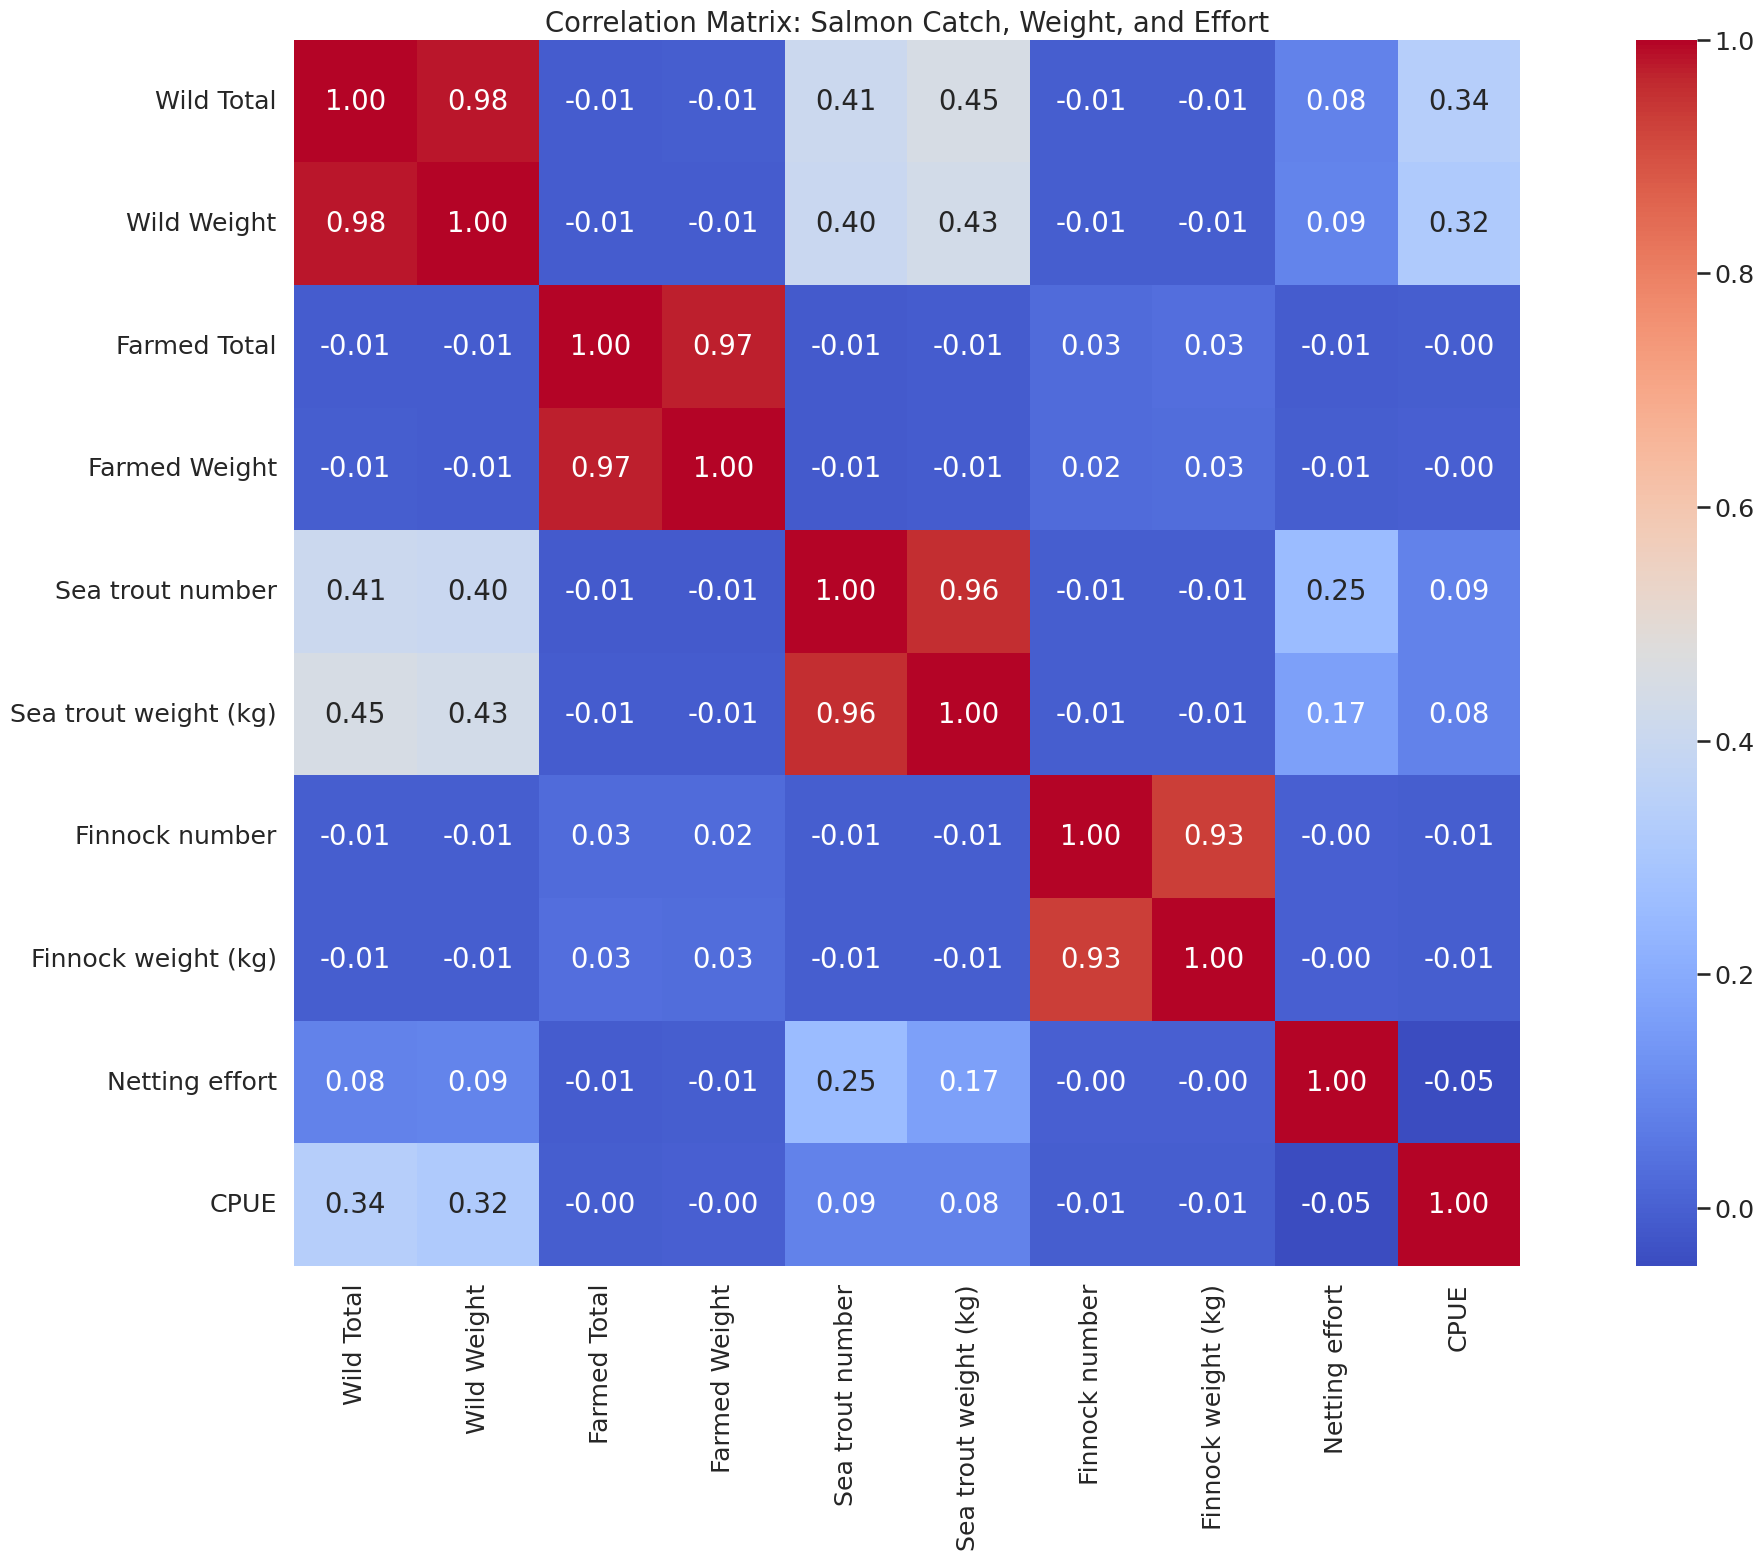

In [38]:
# Compute additional useful fields
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
df['Wild Weight'] = df['Wild MSW weight (kg)'].fillna(0) + df['Wild 1SW weight (kg)'].fillna(0)
df['Farmed Total'] = df['Farmed MSW number'].fillna(0) + df['Farmed 1SW number'].fillna(0)
df['Farmed Weight'] = df['Farmed MSW weight (kg)'].fillna(0) + df['Farmed 1SW weight (kg)'].fillna(0)
df['CPUE'] = df['Wild Total'] / df['Netting effort'].replace(0, np.nan)

# Select numeric variables for correlation
numeric_cols = [
    'Wild Total', 'Wild Weight',
    'Farmed Total', 'Farmed Weight',
    'Sea trout number', 'Sea trout weight (kg)',
    'Finnock number', 'Finnock weight (kg)',
    'Netting effort', 'CPUE'
]

# Drop rows with missing values in selected columns
corr_df = df[numeric_cols].dropna()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix: Salmon Catch, Weight, and Effort")
plt.tight_layout()
plt.show()

In [35]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 1. Create total count columns
# df['Wild Total'] = df['Wild MSW number'] + df['Wild 1SW number']

# # 2. Group by Region (or District)
# summary = df.groupby('Region').agg({
#     'Wild Total': 'sum',
#     'Wild MSW number': 'sum'
# }).reset_index()

# # 3. Calculate share of large salmon
# summary['% Large (MSW)'] = summary['Wild MSW number'] / summary['Wild Total'] * 100

# # 4. Sort by both high count and high MSW %
# summary_sorted = summary.sort_values(['Wild Total', '% Large (MSW)'], ascending=False)

# # 5. Plot both metrics
# fig, ax1 = plt.subplots(figsize=(14, 6))

# sns.set_style("whitegrid")
# sns.set_context("talk", font_scale=1.1)

# # Bar plot for Wild Total
# sns.barplot(data=summary_sorted, x='Region', y='Wild Total', ax=ax1, color='skyblue')
# ax1.set_ylabel("Total Salmon Caught", fontsize=13, color='skyblue')
# ax1.tick_params(axis='y', labelcolor='skyblue')

# # Line plot for % Large MSW
# ax2 = ax1.twinx()
# sns.lineplot(data=summary_sorted, x='Region', y='% Large (MSW)', ax=ax2, marker='o', color='darkred', linewidth=2)
# ax2.set_ylabel("% of Large (MSW) Salmon", fontsize=13, color='darkred')
# ax2.tick_params(axis='y', labelcolor='darkred')

# # Title
# plt.title("Where to Catch the Most and Largest Salmon", fontsize=16, fontweight='bold')
# plt.xlabel("Region")

# plt.tight_layout()
# plt.show()


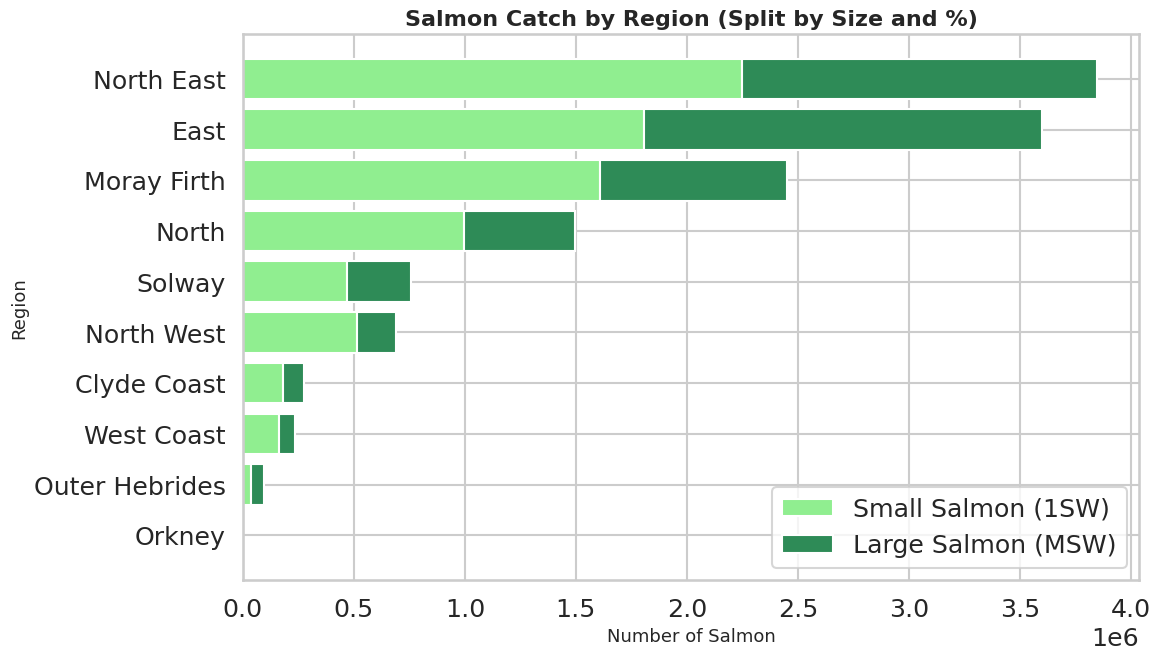

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate by Region
summary = df.groupby('Region')[['Wild MSW number', 'Wild 1SW number']].sum().reset_index()

# 2. Compute totals and percentages
summary['Wild Total'] = summary['Wild MSW number'] + summary['Wild 1SW number']
summary['% MSW'] = summary['Wild MSW number'] / summary['Wild Total'] * 100
summary['% 1SW'] = summary['Wild 1SW number'] / summary['Wild Total'] * 100

# 3. Sort by total
summary = summary.sort_values('Wild Total', ascending=True)

# 4. Plot
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(12, 7))

# Bar segments
bar_1sw = plt.barh(summary['Region'], summary['Wild 1SW number'], color='lightgreen', label='Small Salmon (1SW)')
bar_msw = plt.barh(summary['Region'], summary['Wild MSW number'],
                   left=summary['Wild 1SW number'], color='seagreen', label='Large Salmon (MSW)')

# # 5. Add percentage labels (only if width is wide enough)
# for i, row in summary.iterrows():
#     # Label for 1SW
#     if row['Wild 1SW number'] > 1000:
#         plt.text(row['Wild 1SW number'] / 2, i, f"{row['% 1SW']:.0f}%",
#                  va='center', ha='center', color='black', fontsize=10)
#     # Label for MSW
#     if row['Wild MSW number'] > 1000:
#         plt.text(row['Wild 1SW number'] + row['Wild MSW number'] / 2, i, f"{row['% MSW']:.0f}%",
#                  va='center', ha='center', color='white', fontsize=10, fontweight='bold')

# Titles and labels
plt.title("Salmon Catch by Region (Split by Size and %)", fontsize=16, fontweight='bold')
plt.xlabel("Number of Salmon", fontsize=13)
plt.ylabel("Region", fontsize=13)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
